# Playground2: Kilosort + Template Metrics

In [1]:
from pathlib import Path
import spikeinterface.full as si

print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.103.3


In [2]:
# Check if Kilosort output already exists

# For kilosort/phy output files we can use the read_phy
# most formats will have a read_xx that can used.
analyzer = si.load_sorting_analyzer('/Users/jf5479/Downloads/M25_D18/kilosort4_sa')


/Users/jf5479/Dropbox/Python/spikeinterface/src/spikeinterface/core/base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


In [3]:
# Random spikes selection
if not analyzer.has_extension("random_spikes"):
    print("Computing random_spikes...")
    analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)

In [4]:
# Waveforms
if not analyzer.has_extension("waveforms"):
    print("Computing waveforms...")
    analyzer.compute("waveforms", ms_before=1.5, ms_after=2.0, **job_kwargs)

In [5]:
# Templates
if not analyzer.has_extension("templates"):
    print("Computing templates...")
    analyzer.compute("templates", operators=["average", "median", "std"])

In [53]:
# Noise levels
if not analyzer.has_extension("noise_levels"):
    print("Computing noise_levels...")
    analyzer.compute("noise_levels")

##  Compute Template Metrics

In [6]:
# Compute template metrics with multi-channel metrics included
# Delete the old cached extension first

# Then recompute
analyzer.compute(
    "template_metrics",
    smooth=True,
    smooth_window_frac=0.1,
    smooth_polyorder=3,
    min_thresh_detect_peaks_troughs=0.4
)


/Users/jf5479/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 1000 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/jf5479/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 1000 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/jf5479/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 1000 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/jf5479/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 1000 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/jf5479/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 10

In [7]:


# Get the metrics as a DataFrame
template_metrics = analyzer.get_extension("template_metrics").get_data()
template_metrics

,peak_to_trough_duration,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks,waveform_duration,peak_before_to_trough_ratio,peak_after_to_trough_ratio,peak_before_to_peak_after_ratio,main_peak_to_trough_ratio,trough_width,peak_before_width,peak_after_width,waveform_baseline_flatness,velocity_above,velocity_below,exp_decay,spread
0,0.000930,-0.391377,0.000217,48304.384356,-11509.478867,2,1,930.000000,0.281250,0.391377,0.718618,0.391377,339.416196,NaN,996.954546,0.320548,NaN,1968.672345,0.011912,180.0
1,0.000993,-0.559453,0.000607,19480.348714,-30323.760290,2,1,890.000000,1.005980,0.559453,1.798148,1.005980,804.599484,752.785561,299.439215,0.445078,-1150.976105,395.389870,0.017526,180.0
2,0.000467,-0.196339,0.000210,54427.516428,-3144.791432,2,1,466.666667,0.166725,0.196339,0.849167,0.196339,250.587237,567.387928,828.894898,0.180007,70.256344,-850.000000,0.022914,75.0
3,0.000837,-0.331457,0.000203,87707.717569,-9623.441262,2,1,836.666667,0.241981,0.331457,0.730053,0.331457,284.207039,NaN,1051.925666,0.273670,1104.061445,1500.544772,0.016225,180.0
4,0.000597,-0.431754,0.000343,57011.717748,-11030.357085,2,1,596.666667,0.179789,0.431754,0.416416,0.431754,377.873485,412.239605,584.726183,0.184279,-303.266685,NaN,0.034594,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0.000927,-0.640045,0.000503,32619.897138,-16025.030223,2,1,926.666667,0.351054,0.640045,0.548484,0.640045,602.278842,253.236408,727.313733,0.366593,NaN,1285.624797,NaN,180.0
372,0.000653,-0.174707,0.000150,230009.965415,-14782.371126,2,1,653.333333,0.075224,0.174707,0.430571,0.174707,196.679473,80.050997,647.211641,0.098756,NaN,371.169649,0.032790,45.0
373,0.000773,-0.351117,0.000240,33768.217742,-4993.292180,2,1,773.333333,0.220369,0.351117,0.627622,0.351117,302.944762,200.943300,724.343500,0.226603,-732.014874,-387.998015,0.012231,75.0
374,0.000723,-0.373636,0.000240,23095.225222,-5458.678401,2,1,723.333333,0.111326,0.373636,0.297953,0.373636,356.978504,157.402821,777.102803,0.330019,NaN,-128.602566,0.011870,60.0


In [7]:
# Spike amplitudes
if not analyzer.has_extension("spike_amplitudes"):
    print("Computing spike_amplitudes...")
    analyzer.compute("spike_amplitudes")

In [8]:
# Correlograms
if not analyzer.has_extension("correlograms"):
    print("Computing correlograms...")
    analyzer.compute("correlograms")

In [8]:
analyzer.compute(
    "quality_metrics",
)

/Users/jf5479/Dropbox/Python/spikeinterface/src/spikeinterface/core/analyzer_extension_core.py:1032: UserWarning: Metric sd_ratio requires a recording. Since the SortingAnalyzer has no recording, the metric will not be computed.
  warnings.warn(
/Users/jf5479/Dropbox/Python/spikeinterface/src/spikeinterface/core/analyzer_extension_core.py:1040: UserWarning: The following metrics will not be computed due to missing dependencies: ['mahalanobis', 'd_prime', 'sd_ratio', 'silhouette', 'nearest_neighbor']
  warnings.warn(
/Users/jf5479/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jf5479/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jf5479/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: inv

In [9]:
# Quality metrics
if not analyzer.has_extension("quality_metrics"):
    print("Computing quality_metrics...")
    analyzer.compute("quality_metrics")

quality_metrics = analyzer.get_extension("quality_metrics").get_data()
quality_metrics

,num_spikes,firing_rate,presence_ratio,snr,snr_bombcell,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,...,amplitude_cv_median,amplitude_cv_range,amplitude_cutoff,noise_cutoff,noise_ratio,amplitude_median,drift_ptp,drift_std,drift_mad,sd_ratio
0,70860,16.569565,1.000000,2.997902,21.794119,1.482813,5223,1.000000,4899,NaN,...,NaN,NaN,0.000089,-0.129627,0.041261,-17.355000,2.781601,0.623276,0.467753,2.223717
1,35219,8.235443,1.000000,1.515432,19.924999,0.935490,814,1.000000,627,NaN,...,2.064498,1.489093,0.000082,-0.225793,0.024113,-5.264999,3.083042,0.672090,0.520758,1.821735
2,22971,5.371429,1.000000,2.459971,22.950001,0.083747,31,0.107035,25,0.105,...,0.461843,0.458329,0.000011,-0.038763,0.015673,-13.844999,1.776146,0.446181,0.384374,1.009472
3,38556,9.015752,1.000000,3.150455,17.388889,1.845931,1925,1.000000,1794,NaN,...,0.933989,0.471161,0.000179,-0.046065,0.042872,-18.719999,3.046326,0.677080,0.502092,2.171387
4,25600,5.986182,1.000000,3.088286,25.347828,0.746076,343,1.000000,285,NaN,...,NaN,NaN,0.000058,-0.221197,0.018106,-17.160000,4.121138,0.547034,0.892043,1.144326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,685,0.160177,0.464789,2.362186,48.705883,689.625782,227,1.000000,204,NaN,...,NaN,NaN,0.000445,-0.391426,0.013178,-9.945000,NaN,NaN,NaN,1.711817
372,31850,7.447653,1.000000,10.522679,28.590910,0.001405,1,0.002110,1,0.005,...,NaN,NaN,0.000108,-0.090904,0.056504,-57.719997,4.326493,0.647887,0.567893,1.075722
373,13935,3.258494,1.000000,1.511464,32.826088,0.249594,34,0.168328,14,0.175,...,1.168065,1.922004,0.000028,-0.169045,0.013893,-7.605000,1.844368,0.225273,0.309508,1.390354
374,13567,3.172443,1.000000,1.298798,33.615387,0.727996,94,0.449561,30,0.225,...,1.558193,3.098256,0.000019,-0.133455,0.007452,-7.994999,1.490345,0.200480,0.246163,1.959414


In [10]:
import pandas as pd
import numpy as np
import spikeinterface.comparison as sc  
# Get metrics from SortingAnalyzer
qm = analyzer.get_extension("quality_metrics").get_data()
tm = analyzer.get_extension("template_metrics").get_data()
metrics = pd.concat([qm, tm], axis=1)

qm

,num_spikes,firing_rate,presence_ratio,snr,snr_bombcell,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,...,amplitude_cv_median,amplitude_cv_range,amplitude_cutoff,noise_cutoff,noise_ratio,amplitude_median,drift_ptp,drift_std,drift_mad,sd_ratio
0,70860,16.569565,1.000000,2.997902,21.794119,1.482813,5223,1.000000,4899,NaN,...,NaN,NaN,0.000089,-0.129627,0.041261,-17.355000,2.781601,0.623276,0.467753,2.223717
1,35219,8.235443,1.000000,1.515432,19.924999,0.935490,814,1.000000,627,NaN,...,2.064498,1.489093,0.000082,-0.225793,0.024113,-5.264999,3.083042,0.672090,0.520758,1.821735
2,22971,5.371429,1.000000,2.459971,22.950001,0.083747,31,0.107035,25,0.105,...,0.461843,0.458329,0.000011,-0.038763,0.015673,-13.844999,1.776146,0.446181,0.384374,1.009472
3,38556,9.015752,1.000000,3.150455,17.388889,1.845931,1925,1.000000,1794,NaN,...,0.933989,0.471161,0.000179,-0.046065,0.042872,-18.719999,3.046326,0.677080,0.502092,2.171387
4,25600,5.986182,1.000000,3.088286,25.347828,0.746076,343,1.000000,285,NaN,...,NaN,NaN,0.000058,-0.221197,0.018106,-17.160000,4.121138,0.547034,0.892043,1.144326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,685,0.160177,0.464789,2.362186,48.705883,689.625782,227,1.000000,204,NaN,...,NaN,NaN,0.000445,-0.391426,0.013178,-9.945000,NaN,NaN,NaN,1.711817
372,31850,7.447653,1.000000,10.522679,28.590910,0.001405,1,0.002110,1,0.005,...,NaN,NaN,0.000108,-0.090904,0.056504,-57.719997,4.326493,0.647887,0.567893,1.075722
373,13935,3.258494,1.000000,1.511464,32.826088,0.249594,34,0.168328,14,0.175,...,1.168065,1.922004,0.000028,-0.169045,0.013893,-7.605000,1.844368,0.225273,0.309508,1.390354
374,13567,3.172443,1.000000,1.298798,33.615387,0.727996,94,0.449561,30,0.225,...,1.558193,3.098256,0.000019,-0.133455,0.007452,-7.994999,1.490345,0.200480,0.246163,1.959414


{'total_units': 376, 'counts': {'NOISE': 112, 'GOOD': 55, 'MUA': 183, 'NON_SOMA': 26}, 'percentages': {'NOISE': 29.8, 'GOOD': 14.6, 'MUA': 48.7, 'NON_SOMA': 6.9}}


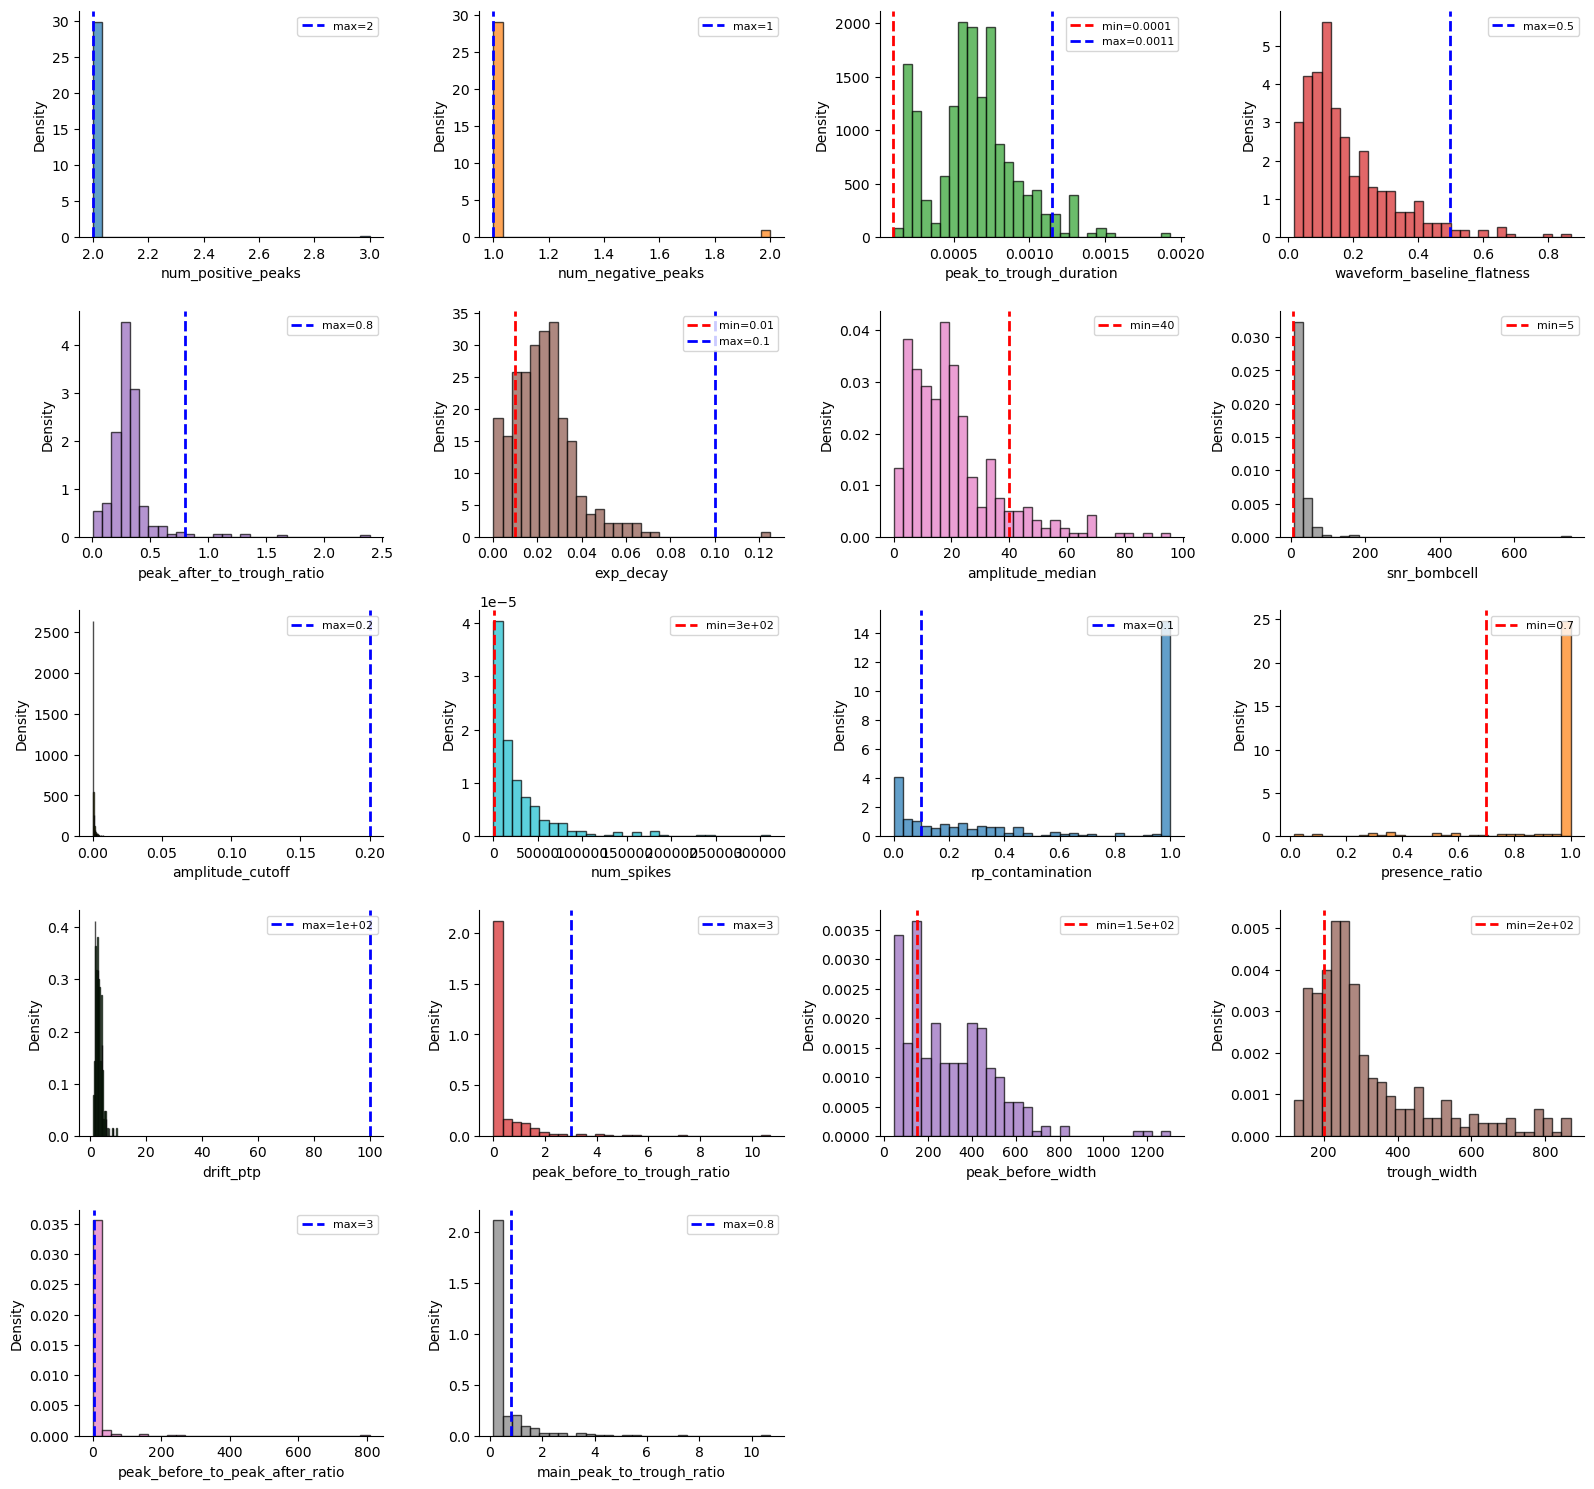

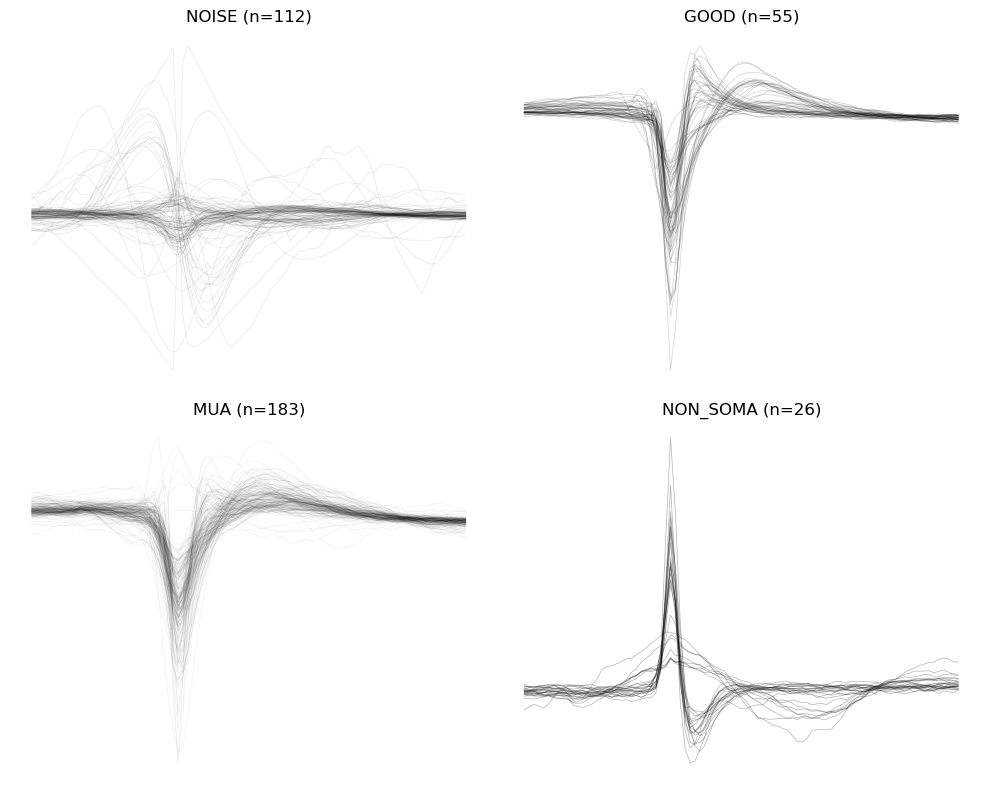

In [11]:


# Classify with default thresholds
unit_type, labels = sc.classify_units(metrics)

# Or customize thresholds
thresholds = sc.get_default_thresholds() # probably not correct format. where should i put this? 
thresholds["snr_bombcell"]["min"] = 3  # Lower threshold
thresholds["amplitude_median"]["min"] = np.nan  # Disable

unit_type, labels = sc.classify_units(metrics, thresholds)

# plots!
# Get summary
summary = sc.get_classification_summary(unit_type, labels)
print(summary)

import spikeinterface.widgets as sw
# Plot histograms with threshold lines
sw.plot_classification_histograms(metrics)

# Plot waveform overlay by type
sw.plot_waveform_overlay(analyzer, unit_type, labels)






In [16]:
unit_type
labels

array(['NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE', 'NOISE',
       'NOISE', 'NOI

## Summary

In [ ]:
print(f"Total units: {len(sorting.unit_ids)}")
print(f"Analyzer saved to: {analyzer_folder}")
print(f"\nAvailable extensions:")
for ext_name in analyzer.get_loaded_extension_names():
    print(f"  - {ext_name}")

In [ ]:
# Combine metrics
combined_metrics = template_metrics.join(quality_metrics, how="outer")
combined_metrics

In [ ]:
# Save metrics to CSV
output_folder.mkdir(parents=True, exist_ok=True)
metrics_csv = output_folder / "combined_metrics.csv"
combined_metrics.to_csv(metrics_csv)
print(f"Metrics saved to: {metrics_csv}")